# Sentinel-2 snow cover

#### Import libraries

In [5]:
# Sentinel Hub
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions, geometry)

# Geospatial libraries
import geopandas as gpd

from datetime import date

import folium

#### Sentinel-hub authentication

In [2]:
config = SHConfig()
config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET

#### Input definition

Read the shapefile on which to compute the snow cover map and plot it

In [3]:
# Read the file with geopandas and convert it to EPSG:4326
aoi_df = gpd.read_file('ADO_DSC_ITH1_0025.geojson')
aoi_df = aoi_df.to_crs(4326)

# Create a basemap with folium
m = folium.Map(
    location=[aoi_df.to_crs(4326).iloc[0].geometry.centroid.y, aoi_df.to_crs(4326).iloc[0].geometry.centroid.x],
    zoom_start=11)

# Add the polygon to the map
geo_j = folium.GeoJson(data=aoi_df.to_json())
geo_j.add_to(m)

# Show the map
m

Select a date

In [6]:
start_date = date(2018, 4, 1)
end_date = date(2018, 4, 15)

#### Snowcover map generation

Generate the snow cover map on the selected AOI and date from S2L1C

In [8]:
evalscript_snowcover = """

//VERSION=3

function setup() {
  return {
    input: ["B03", "B04", "B08", "B11", "CLM", "dataMask"],
    output: {bands: 1, sampleType: "UINT8"}
  };
}

function calc_snow_mask(NDVI, NDSI, B03){
 
  let si = (NDSI >= 0.4) ? 1 : (Math.abs(NDVI - 0.1) <= 0.025 ? 1 : 0);
  let br = B03 > 0.3;
 
  return si && br;
}

function evaluatePixel(sample) {
  
  // Calculate indices
  var NDSI = (sample.B03 - sample.B11) / (sample.B03 + sample.B11);
  var NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  
  // Calculate snowmask
  var snow = calc_snow_mask(NDVI, NDSI, sample.B03);  
  
  // Create the snow mask with clouds
  if (sample.dataMask == 0){
      return [0];
  }
  else if (sample.CLM == 1){
      return [3];
  }
  else if (snow == 1){
      return [1];
  }
  else if (snow == 0){
      return [2];
  }
  

}
"""

aoi = geometry.Geometry(aoi_df.geometry.iloc[0], CRS.WGS84)

request_snowcover = SentinelHubRequest(
    evalscript=evalscript_snowcover,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=(start_date, end_date),
        )
    ],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    geometry=aoi,
    size=bbox_to_dimensions(aoi.bbox, resolution=100),
    config=config
)

snowcover = request_snowcover.get_data()

In [11]:
len(snowcover)

1

Generate the corresponding RGB image

In [10]:
# The evalscript for RGB map creation
evalscript_rgb = """
 //VERSION=3
function setup(){
  return{
    input: ["B02", "B03", "B04", "dataMask"],
    output: {bands: 4}
  }
}

function evaluatePixel(sample){
  // Set gain for visualisation
  let gain = 2.5;
  // Return RGB
  return [sample.B04 * gain, sample.B03 * gain, sample.B02 * gain, sample.dataMask];
}
"""
request_rgb = SentinelHubRequest(
    evalscript=evalscript_rgb,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=(date, date),
        )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    geometry=aoi,
    size=bbox_to_dimensions(aoi.bbox, resolution=10),
    config=config
)
rgb_response = request_rgb.get_data()

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/process
with HTTPError:
400 Client Error: Bad Request for url: https://services.sentinel-hub.com/api/v1/process
Server response: "{"status": 400, "reason": "Bad Request", "message": "Invalid request", "code": "COMMON_BAD_PAYLOAD", "errors": [{"parameter": "output->width", "invalidValue": 2881, "violation": "must be less than or equal to 2500", "description": "The request image width. Must be an integer between 1 and 2500. <br />*Only one pair of parameters \"width\"/\"height\" or \"resx\"/\"resy\" must be set at the same time.*"}, {"parameter": "output->height", "invalidValue": 3058, "violation": "must be less than or equal to 2500", "description": "The request image height. Must be an integer between 1 and 2500. <br />*Only one pair of parameters \"width\"/\"height\" or \"resx\"/\"resy\" must be set at the same time.*"}]}"

#### Show the result

In [ ]:
# Create a basemap with folium
m = folium.Map(
    location=aoi.bbox.middle[::-1],
    zoom_start=11)

# Color map for the snow cover (0 no data: transparent, 1 snow: white, 2 snow-free: green, 3 cloud: gray)
cmap = ((0, 0, 0, 0), (1, 1, 1, 1), (0, 0.6, 0.3, 1), (0.5, 0.5, 0.5, 1))

# Add the snow cover to the map
folium.raster_layers.ImageOverlay(
    snowcover[0],
    bounds=[aoi.bbox.lower_left[::-1], aoi.bbox.upper_right[::-1]],
    name='snow cover',
    colormap=lambda x: cmap[x]
).add_to(m)

# Add the Sentinel-2 RGB to the map
folium.raster_layers.ImageOverlay(
    rgb_response[0]/255,
    bounds=[aoi.bbox.lower_left[::-1], aoi.bbox.upper_right[::-1]],
    name='RGB',
).add_to(m)

# Add the layer control
folium.LayerControl().add_to(m)

# Show the map
m

In [11]:
snowcover

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

In [12]:
# Create a basemap with folium
m = folium.Map(
    location=aoi.bbox.middle[::-1],
    zoom_start=11)

# Color map for the snow cover (0 no data: transparent, 1 snow: white, 2 snow-free: green, 3 cloud: gray)
cmap = ((0, 0, 0, 0), (1, 1, 1, 1), (0, 0.6, 0.3, 1), (0.5, 0.5, 0.5, 1))

# Add the snow cover to the map
folium.raster_layers.ImageOverlay(
    snowcover[0],
    bounds=[aoi.bbox.lower_left[::-1], aoi.bbox.upper_right[::-1]],
    name='snow cover',
    colormap=lambda x: cmap[x]
).add_to(m)


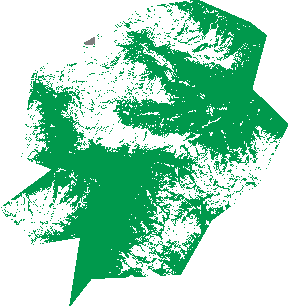

In [13]:
m